## Expanded TV Exposure Data and Process
* The raw data we receive from D&K contains2 files: one exposure (xxxx-exposure.txt) one unification
* **Exposure file: xxxx-exposure.txt. Expanded TV exposure (NPM+STB) is household level data by exposure date, network/program and exposure count**

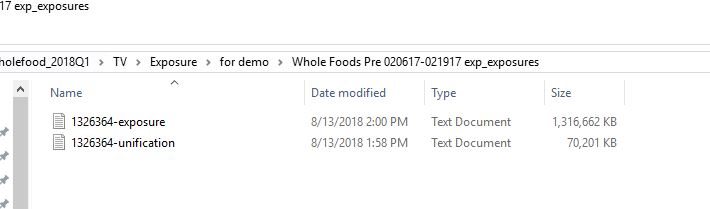

In [1]:
from IPython.display import Image
Image(filename='img/Expanded TV.JPG')

In [3]:
import pandas as pd
import zipfile, os
import pickle
from IPython.display import display
pd.options.display.max_columns = None

* The following code is to show you how the raw exposure data looks like. You can skip this if you want.

In [3]:
exppath_demo = r'S:\NBI_Sales_Effect\Wholefood_2018Q1\TV\for demo\Whole Foods Pre 020617-021917 exp_exposures'
df_demo= pd.read_csv(exppath_demo+"\\1326364-exposure.txt",sep="|", chunksize=5)
print(next(df_demo))

    HHLD_ID  EXPOSED_DT  SCHEDULE_ID     SPOT_ID  MEDIA_ID MEDIA_DESC  \
0  10748200    20170208       114146  3665904041         8  Broadcast   
1  10748200    20170208       114146  3697101928         8  Broadcast   
2  10748200    20170208       114146  3702804130         8  Broadcast   
3  10748200    20170208       114146  3711603969         8  Broadcast   
4  10748200    20170214       114146  4317406871         8  Broadcast   

   ORIGINATOR_ID ORIGINATOR_DESC  BRAND_ID                      BRAND_DESC  \
0             78             CBS    205904  WHOLE FOODS MARKET SUPERMARKET   
1             78             CBS    205904  WHOLE FOODS MARKET SUPERMARKET   
2             78             CBS    205904  WHOLE FOODS MARKET SUPERMARKET   
3             78             CBS    205904  WHOLE FOODS MARKET SUPERMARKET   
4             78             CBS    205904  WHOLE FOODS MARKET SUPERMARKET   

                              CREATIVE ADVERTISEMENT_CODE  \
0  MAN/FRUITS & VEGETABLES/WOMA

# Exposure process script starts from here
* **First, we will load all zip files and read the xxx-exposure.txt** 

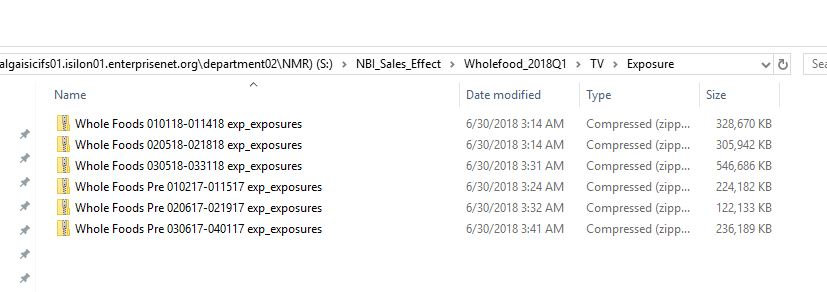

In [4]:
Image(filename='img/exposure zip.JPG')

In [4]:
exppath = r'S:\NBI_Sales_Effect\Wholefood_2018Q1\TV\Exposure'
outpath = r'F:\SE\wholefood'
filenames=os.listdir(exppath)
print(filenames)

['Whole Foods 010118-011418 exp_exposures.zip', 'Whole Foods 020518-021818 exp_exposures.zip', 'Whole Foods 030518-033118 exp_exposures.zip', 'Whole Foods Pre 010217-011517 exp_exposures.zip', 'Whole Foods Pre 020617-021917 exp_exposures.zip', 'Whole Foods Pre 030617-040117 exp_exposures.zip']


* **agg_exp_breaks is an user defined function to read 'xxxx-exposure.txt' in .zip files, only get relevent columns (this will depend on the PRF), get daily impression counts and output HHLD by exposure counts**

* Depending on the request, you may need different columns, which means your "usecols" argument in pd.read_csv will be different 
* If you want exposure breaks by network, use ['HHLD_ID','EXPOSED_DT','ORIGINATOR_DESC','EXPOSURE_COUNTS']
* If you want exposure breaks by daypart, use ['HHLD_ID','EXPOSED_DT','DAYPART','EXPOSURE_COUNTS']
* If no additioanl breaks required, use use ['HHLD_ID','EXPOSED_DT','EXPOSURE_COUNTS']
* In this example (wholefood campaign), there is no additioanl breaks required

In [6]:
def agg_exp_breaks(exppath, outpath, file, out_dfn):
    zpfiles = zipfile.ZipFile(exppath+'\\'+file,"r")
    csv_files = zpfiles.infolist()
    for csvfile in csv_files:
        # To read only exposure in the zip file
        if 'exposure' in csvfile.filename:
            #again, your may want change "usecols" if PRF says differently
            exp_df=pd.read_csv(zpfiles.open(csvfile.filename), sep="|"
                       , usecols=['HHLD_ID','EXPOSED_DT','EXPOSURE_COUNTS'], parse_dates=['EXPOSED_DT'])
            #daily impression : get sum of exposure count by exposure date
            imp = exp_df.groupby('EXPOSED_DT')['EXPOSURE_COUNTS'].sum().reset_index(level='EXPOSED_DT')
            imp.to_csv(outpath+'\\'+out_dfn+'_imp.csv', index=False)
            #final aggregagted exposure dataframe : get sum of exposure count by household ID (HHLD_ID)
            #You many want to groupby more than just household ID, depending on PRF. 
            expgroupby_df = exp_df.groupby('HHLD_ID')['EXPOSURE_COUNTS'].sum().reset_index(name=out_dfn)
            #print row count for the final aggregagted exposure dataframe
            print(out_dfn+ " ---- " + str(len(expgroupby_df)))
            return(expgroupby_df)

*  **if you only have 1 or 2 file or you don't wnat to use for loop. You can do the following : ** 
* Jan18_Exp = agg_exp_breaks(exppath, outpath, 'Whole Foods 010118-011418 exp_exposures.zip', 'Jan18_Exp')  
  Feb18_exp = agg_exp_breaks(exppath, outpath, 'Whole Foods 020518-021818 exp_exposures.zip', 'Feb18_exp')  
  totalexp=pd.merge(Jan18_Exp, Feb18_exp, on='HHLD_ID', how='outer').fillna(0)


* **If you have multiple files to process and want to use loop you can do the following : ** (In this example, I have 6 files that I need to process, so I use loop)

In [7]:
# the order of expvars and filenames has to be the same!!!
# For example, 
#{'Whole Foods 010118-011418 exp_exposures.zip': 'Jan18_exp',
#'Whole Foods 020518-021818 exp_exposures.zip': 'Feb18_exp',
#'Whole Foods 030518-033118 exp_exposures.zip': 'Mar18_exp',
#'Whole Foods Pre 010217-011517 exp_exposures.zip': 'Jan17_exp',
#'Whole Foods Pre 020617-021917 exp_exposures.zip': 'Feb17_exp',
#'Whole Foods Pre 030617-040117 exp_exposures.zip': 'Mar17_exp'}
expvars = ['Jan18_exp','Feb18_exp','Mar18_exp','Jan17_exp','Feb17_exp','Mar17_exp']
filenames = os.listdir(exppath)
totalexp=  pd.DataFrame()
for filename, expvar in zip(filenames, expvars):
    globals()[expvar]= agg_exp_breaks(exppath, outpath, filename, expvar)
    if totalexp.empty:
        totalexp=globals()[expvar]
    else:
        totalexp=pd.merge(totalexp, globals()[expvar], on='HHLD_ID', how='outer').fillna(0)
print(totalexp[:5])

Jan18_exp ---- 1637872
Feb18_exp ---- 1483928
Mar18_exp ---- 1733299
Jan17_exp ---- 1390365
Feb17_exp ---- 1310734
Mar17_exp ---- 1486519
    HHLD_ID  Jan18_exp  Feb18_exp  Mar18_exp  Jan17_exp  Feb17_exp  Mar17_exp
0    980100        2.0        1.0        0.0        0.0        0.0        1.0
1  10125100        2.0        0.0       12.0        0.0        0.0        0.0
2  10158200        1.0        3.0       10.0        0.0        0.0        0.0
3  10343100        2.0       10.0        8.0        0.0        0.0        0.0
4  10469100        2.0        0.0        0.0        0.0        0.0        0.0


* QA1: We would expect each fle will have similar counts. You may want to reach out to D&K if one file's size is clearly way more bigger than the others.
* QA2: Check imp.csv in your output folder to see if the number of impression is consistent across the campaign period. You may see  number of impression is low at the beginning and end of the campaign, which is normal.

In [8]:
totalexp.shape 

(2838798, 7)

In [ ]:
totalexp.to_pickle(exppath+'totalexp_wholefood')

* **read_unification is a function that read "xxx-unification.txt" in the zip file, check the date in the file and dedup the HHLD_ID**

In [12]:
def read_unification(exppath, outpath, file, uni_colname):
    zpfiles = zipfile.ZipFile(exppath+'\\'+file,"r")
    csv_files = zpfiles.infolist()
    for csvfile in csv_files:
        if 'unification' in csvfile.filename:
            uni_df = pd.read_csv(zpfiles.open(csvfile.filename),sep="|")
            print("the date range and count in file " + uni_colname+ " : ")
            print(uni_df.groupby(['UNIF_START_DT','UNIF_END_DT']).size())
            uni_df = uni_df[['HHLD_ID']].drop_duplicates(['HHLD_ID'])
            uni_df[uni_colname] = 1
            return(uni_df)

*  **if you only have 1 or 2 file or you don't wnat to use for loop. You can do the following : ** 
* Jan18_Uni = read_unification(exppath, outpath, 'Whole Foods 010118-011418 exp_exposures.zip', 'Jan18_Uni')  
  Feb18_Uni = read_unification(exppath, outpath, 'Whole Foods 020518-021818 exp_exposures.zip', 'Feb18_Uni')  
  unification=pd.merge(Feb18_Uni, Jan18_Uni, on='HHLD_ID', how='outer').fillna(0)

In [15]:
##unification by file
univars= ['Jan18_unif','Feb18_unif','Mar18_unif','Jan17_unif','Feb17_unif','Mar17_unif']
filenames=os.listdir(exppath)
unification=pd.DataFrame()
for filename, univar in zip(filenames, univars):
    globals()[univar]= read_unification(exppath, outpath, filename, univar)
    if unification.empty:
        unification=globals()[univar]
    else:
        unification=pd.merge(unification, globals()[univar], on='HHLD_ID', how='outer').fillna(0)
print("total number of row in unification is ", str(len(unification)))
print(unification[:5])

the date range in file Jan18_unif : 
UNIF_START_DT  UNIF_END_DT
20180101       20180114       2257498
dtype: int64
the date range in file Feb18_unif : 
UNIF_START_DT  UNIF_END_DT
20180205       20180218       2137853
dtype: int64
the date range in file Mar18_unif : 
UNIF_START_DT  UNIF_END_DT
20180305       20180331       2192742
dtype: int64
the date range in file Jan17_unif : 
UNIF_START_DT  UNIF_END_DT
20170102       20170115       2055799
dtype: int64
the date range in file Feb17_unif : 
UNIF_START_DT  UNIF_END_DT
20170206       20170219       2060449
dtype: int64
the date range in file Mar17_unif : 
UNIF_START_DT  UNIF_END_DT
20170306       20170401       2009865
dtype: int64
total number of row in unification is  3204795
          HHLD_ID  Jan18_unif  Feb18_unif  Mar18_unif  Jan17_unif  Feb17_unif  \
0  87189357837239         1.0         1.0         1.0         1.0         1.0   
1  79074589899254         1.0         1.0         1.0         0.0         0.0   
2  40647230075127   

In [ ]:
unification.to_pickle(exppath+'unification_wholefood')

In [16]:
#Merge unification with totalexp
TV_expfinal=pd.merge(unification, totalexp, on='HHLD_ID', how='left').fillna(0)
TV_expfinal.duplicated('HHLD_ID').any() #False
print(TV_expfinal.shape)
print(TV_expfinal[:5])

(3204795, 13)
          HHLD_ID  Jan18_unif  Feb18_unif  Mar18_unif  Jan17_unif  Feb17_unif  \
0  87189357837239         1.0         1.0         1.0         1.0         1.0   
1  79074589899254         1.0         1.0         1.0         0.0         0.0   
2  40647230075127         1.0         1.0         1.0         1.0         1.0   
3  93498043516208         1.0         1.0         0.0         0.0         0.0   
4  16712266454222         1.0         1.0         1.0         1.0         1.0   

   Mar17_unif  Jan18_exp  Feb18_exp  Mar18_exp  Jan17_exp  Feb17_exp  \
0         1.0        0.0        0.0        0.0        1.0        2.0   
1         0.0        2.0        1.0        2.0        0.0        0.0   
2         1.0        0.0        0.0        0.0        0.0        0.0   
3         0.0        0.0        0.0        0.0        0.0        0.0   
4         1.0        0.0        0.0        0.0        0.0        1.0   

   Mar17_exp  
0        4.0  
1        0.0  
2        0.0  
3     

In [ ]:
#convert HHLD_ID to dpid
mapping= pd.read_csv(r'S:\NBI_Sales_Effect\Expanded TV DPID Conversion\DPID_AHHID_MATCH_20190319.csv')
TV_expfinal_dpid= pd.merge(TV_expfinal, mapping[['DPID','AHHID']], left_on='HHLD_ID', right_on='AHHID', how='left').fillna(0)
print(TV_expfinal_dpid.shape)
print(TV_expfinal_dpid[:5])

In [ ]:
#make sure all HHLD_ID has a matched DPID
TV_expfinal_dpid[TV_expfinal_dpid['DPID']==0]

In [ ]:
TV_expfinal_dpid.to_csv(outpath+"\\Wholefood_exp.csv", index=False)